#### **Context**

The <a href="https://www.kaggle.com/datasets/jillanisofttech/market-segmentation-in-insurance-unsupervised">sample Dataset</a> summarizes the usage behavior of about 9000 active credit cardholders during the last 6 months. The file is at a customer level with 18 behavioral variables.

##### **Credit Card Dataset Column Meanings**

| Column Name | Meaning in Credit Card Context |
|-------------|-------------------------------|
| CUST_ID | Unique identifier for each customer |
| BALANCE | Average balance amount maintained on the credit card |
| BALANCE_FREQUENCY | How frequently the customer maintains a balance (0-1 scale) |
| PURCHASES | Total amount of purchases made using the credit card |
| ONEOFF_PURCHASES | Total amount spent on one-time/single purchases |
| INSTALLMENTS_PURCHASES | Total amount spent on installment purchases |
| CASH_ADVANCE | Total amount taken as cash advances from the credit card |
| PURCHASES_FREQUENCY | How frequently the customer makes purchases (0-1 scale) |
| ONEOFF_PURCHASES_FREQUENCY | How frequently the customer makes one-time purchases (0-1 scale) |
| PURCHASES_INSTALLMENTS_FREQUENCY | How frequently the customer makes installment purchases (0-1 scale) |
| CASH_ADVANCE_FREQUENCY | How frequently the customer takes cash advances (0-1 scale) |
| CASH_ADVANCE_TRX | Number of cash advance transactions made |
| PURCHASES_TRX | Number of purchase transactions made |
| CREDIT_LIMIT | Maximum credit limit available on the card |
| PAYMENTS | Total amount of payments made to the credit card |
| MINIMUM_PAYMENTS | Total amount of minimum payments made |
| PRC_FULL_PAYMENT | Percentage of full payments made (vs. partial payments) |
| TENURE | Number of months the customer has held the credit card |

### Importing necessary packages

In [448]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import IsolationForest, RandomForestRegressor, RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.feature_selection import SelectKBest, mutual_info_classif, VarianceThreshold, mutual_info_regression
from sklearn.model_selection import train_test_split
import shap
from kneed import KneeLocator
from scipy.spatial.distance import cdist

from cluster_visualizer import ClusterVisualizer

import warnings
warnings.filterwarnings('ignore')

### Importing Data and Exploring it

In [449]:
df = pd.read_csv('Customer Data.csv')

In [450]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [451]:
null_counts = df.isna().sum()
null_counts[null_counts > 0]

CREDIT_LIMIT          1
MINIMUM_PAYMENTS    313
dtype: int64

In [452]:
df.describe(include='all')

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
unique,8950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,C19190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,NaN,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,NaN,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,NaN,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,NaN,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000


### Preprocessing

In [453]:
# Drop CUST_ID column before processing
cust_id_df = df['CUST_ID']
df = df.drop('CUST_ID', axis=1)
# Handle missing values by applying IterativeImputer with RandomForestRegressor
df_numeric = df.copy()
imputer = IterativeImputer(estimator=RandomForestRegressor(n_estimators=100, random_state=42))
df = pd.DataFrame(
    imputer.fit_transform(df_numeric), 
    columns=df_numeric.columns,
    index=df_numeric.index
)

# # Remove outliers using IQR method
# iso_forest = IsolationForest(contamination=0.1, random_state=42)
# outliers = iso_forest.fit_predict(df)
# df = df[outliers == 1]

# # Remove top and bottom 1% of values
# numeric_cols = df.select_dtypes(include='number').columns
# upper_bounds = df[numeric_cols].quantile(0.99)
# # Filter outliers in ALL numeric columns simultaneously
# df = df[
#     (df[numeric_cols] <= upper_bounds).all(axis=1)
# ]

df.insert(loc=0, column='CUST_ID', value=cust_id_df)

### Feature Engineering

In [454]:
df_risk = df.copy()


In [455]:

X = df_risk

### Feature Selection

In [456]:
def unsupervised_feature_selection(df, variance_threshold=0.01, correlation_threshold=0.9, 
                                mutual_info_k=None, target_col=None):
    """
    Perform feature selection for unsupervised learning while keeping original column names

    Parameters:
    - df: DataFrame with numerical features
    - variance_threshold: Remove features with variance below this threshold
    - correlation_threshold: Remove one feature from pairs with correlation above this
    - mutual_info_k: Keep top k features based on mutual information (optional)
    - target_col: Column to use for mutual info calculation (optional)
    """

    # Start with all numerical columns
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if target_col and target_col in numerical_cols:
        numerical_cols.remove(target_col)

    selected_features = numerical_cols.copy()
    print(f"Starting with {len(selected_features)} numerical features")

    # 1. Remove low variance features
    selector = VarianceThreshold(threshold=variance_threshold)
    selector.fit(df[selected_features])
    low_variance_features = [feat for feat, selected in zip(selected_features, selector.get_support()) if not selected]
    selected_features = [feat for feat in selected_features if feat not in low_variance_features]
    print(f"Removed {len(low_variance_features)} low variance features")
    print(f"Low variance features: {low_variance_features}")

    # 2. Remove highly correlated features
    corr_matrix = df[selected_features].corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    high_corr_pairs = []
    to_drop = set()

    for col in upper_tri.columns:
        correlated_features = upper_tri[col][upper_tri[col] > correlation_threshold].index.tolist()
        for corr_feat in correlated_features:
            high_corr_pairs.append((col, corr_feat, upper_tri.loc[corr_feat, col]))
            # Keep the feature with higher variance
            if df[col].var() >= df[corr_feat].var():
                to_drop.add(corr_feat)
            else:
                to_drop.add(col)

    selected_features = [feat for feat in selected_features if feat not in to_drop]
    print(f"Removed {len(to_drop)} highly correlated features")
    print(f"High correlation pairs: {high_corr_pairs}")
    print(f"Dropped correlated features: {list(to_drop)}")

    # 3. Optional: Select top K features based on mutual information
    if mutual_info_k and mutual_info_k < len(selected_features):
        if target_col and target_col in df.columns:
            # Use target column for mutual info
            mi_scores = mutual_info_regression(df[selected_features], df[target_col])
        else:
            # Use mean of all features as pseudo-target
            pseudo_target = df[selected_features].mean(axis=1)
            mi_scores = mutual_info_regression(df[selected_features], pseudo_target)

        # Get top k features
        feature_scores = list(zip(selected_features, mi_scores))
        feature_scores.sort(key=lambda x: x[1], reverse=True)
        selected_features = [feat for feat, score in feature_scores[:mutual_info_k]]

        print(f"Selected top {mutual_info_k} features based on mutual information")
        print("Feature importance scores:")
        for feat, score in feature_scores[:mutual_info_k]:
            print(f"  {feat}: {score:.4f}")

    print(f"\nFinal selected features ({len(selected_features)}): {selected_features}")

    return selected_features, {
        'low_variance_removed': low_variance_features,
        'high_corr_removed': list(to_drop),
        'correlation_pairs': high_corr_pairs
    }

# Usage example:
selected_features, removal_info = unsupervised_feature_selection(
    X,
    variance_threshold=0.01,
    correlation_threshold=0.9,
    mutual_info_k=None  # Keep top 10 features
)

# # Get your final dataset with selected features
X_to_scale = X[selected_features]

Starting with 17 numerical features
Removed 0 low variance features
Low variance features: []
Removed 1 highly correlated features
High correlation pairs: [('ONEOFF_PURCHASES', 'PURCHASES', np.float64(0.9168445587151489))]
Dropped correlated features: ['ONEOFF_PURCHASES']

Final selected features (16): ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']


#### Preprocessing Data

In [457]:
for col in ['BALANCE', 'PAYMENTS', 'MINIMUM_PAYMENTS']:
        income_99th = X_to_scale[col].quantile(0.99)
        X_to_scale = X_to_scale[X_to_scale[col] < income_99th]

In [458]:
# 1. Log transform right-skewed features
for feature in X_to_scale.select_dtypes(include=[np.number]).columns:
    if 'RATIO' not in feature:
        X_to_scale[feature] = np.log1p(X_to_scale[feature])

In [459]:
# RobustScaler features
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_to_scale)
X_scaled = pd.DataFrame(X_scaled, columns=X_to_scale.columns, index=X_to_scale.index)

### Clustering Analysis

To determine the optimal number of clusters, I check if the difference is big (<= 1) then I choose silhouette score because it's more objective than KMeans and handles well the imblances in clusters.

In [460]:
X_scaled.dropna(inplace=True)  # Ensure no NaNs after selection

Best kmeans clusters (Silhouette): 2 (score: 0.435)
Best hierarchical clusters (Silhouette): 2 (score: 0.387)


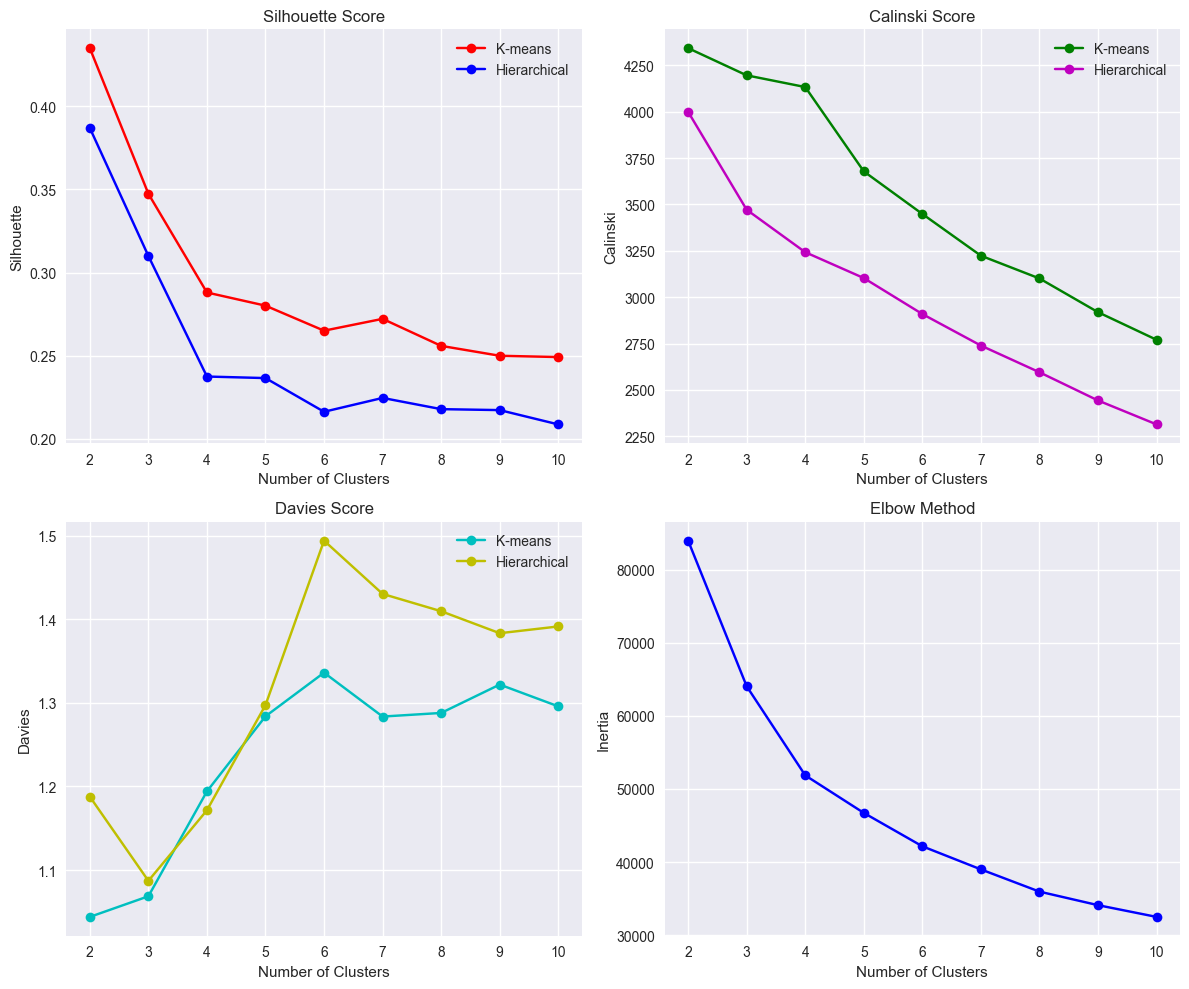

In [461]:
from sklearn.cluster import KMeans, AgglomerativeClustering
def evaluate_clusters(X, max_k=10):
    """Compact clustering evaluation with visualization"""
    K = range(2, max_k + 1)
    methods = {
        'kmeans': lambda k: KMeans(n_clusters=k, random_state=42, n_init=10).fit(X),
        'hierarchical': lambda k: AgglomerativeClustering(n_clusters=k, linkage='ward').fit_predict(X)
    }
    
    # Calculate all metrics
    results = {
        m: {
            'silhouette': [silhouette_score(X, methods[m](k).labels_ if m == 'kmeans' else methods[m](k)) for k in K],
            'calinski': [calinski_harabasz_score(X, methods[m](k).labels_ if m == 'kmeans' else methods[m](k)) for k in K],
            'davies': [davies_bouldin_score(X, methods[m](k).labels_ if m == 'kmeans' else methods[m](k)) for k in K],
            'inertia': [methods[m](k).inertia_ for k in K] if m == 'kmeans' else None
        } for m in methods
    }

    # Plot results
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    metrics = ['silhouette', 'calinski', 'davies']
    styles = [('ro-', 'bo-'), ('go-', 'mo-'), ('co-', 'yo-')]
    
    for i, (metric, (k_style, h_style)) in enumerate(zip(metrics, styles)):
        ax = axes[i//2, i%2]
        ax.plot(K, results['kmeans'][metric], k_style, label='K-means')
        ax.plot(K, results['hierarchical'][metric], h_style, label='Hierarchical')
        ax.set(xlabel='Number of Clusters', ylabel=metric.capitalize(), title=f'{metric.capitalize()} Score')
        ax.legend()
    
    axes[1,1].plot(K, results['kmeans']['inertia'], 'bo-', label='K-means Inertia')
    axes[1,1].set(xlabel='Number of Clusters', ylabel='Inertia', title='Elbow Method')
    plt.tight_layout()
    
    # Print best results
    for m in methods:
        best_k = K[np.argmax(results[m]['silhouette'])]
        print(f"Best {m} clusters (Silhouette): {best_k} (score: {max(results[m]['silhouette']):.3f})")

# Usage
evaluate_clusters(X_scaled)

Hierarchical clustering with k=6 is clearly optimal:
- Elbow method: After 6, the line starts to flatten
- Silhouette: Hierarchical peaks at k=6 (0.325) vs K-means at k=10 (0.297)
- Davies-Bouldin: Both methods minimize around k=6-7, with hierarchical slightly better
- Calinski-Harabasz: Less decisive but shows hierarchical performing well at k=6

In [507]:
### Perform K-means clustering
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

### Risk Segment Profiling

In [508]:
df_risk = X

In [512]:
# Cluster Overview Analysis
import importlib
import cluster_visualizer  # Import the module first
from cluster_visualizer import ClusterVisualizer  # Then import the class

importlib.reload(cluster_visualizer)  # Reload the module
from cluster_visualizer import ClusterVisualizer  # Re-import the class after reload
visualizer = ClusterVisualizer(X_scaled, cluster_labels, selected_features, optimal_k)

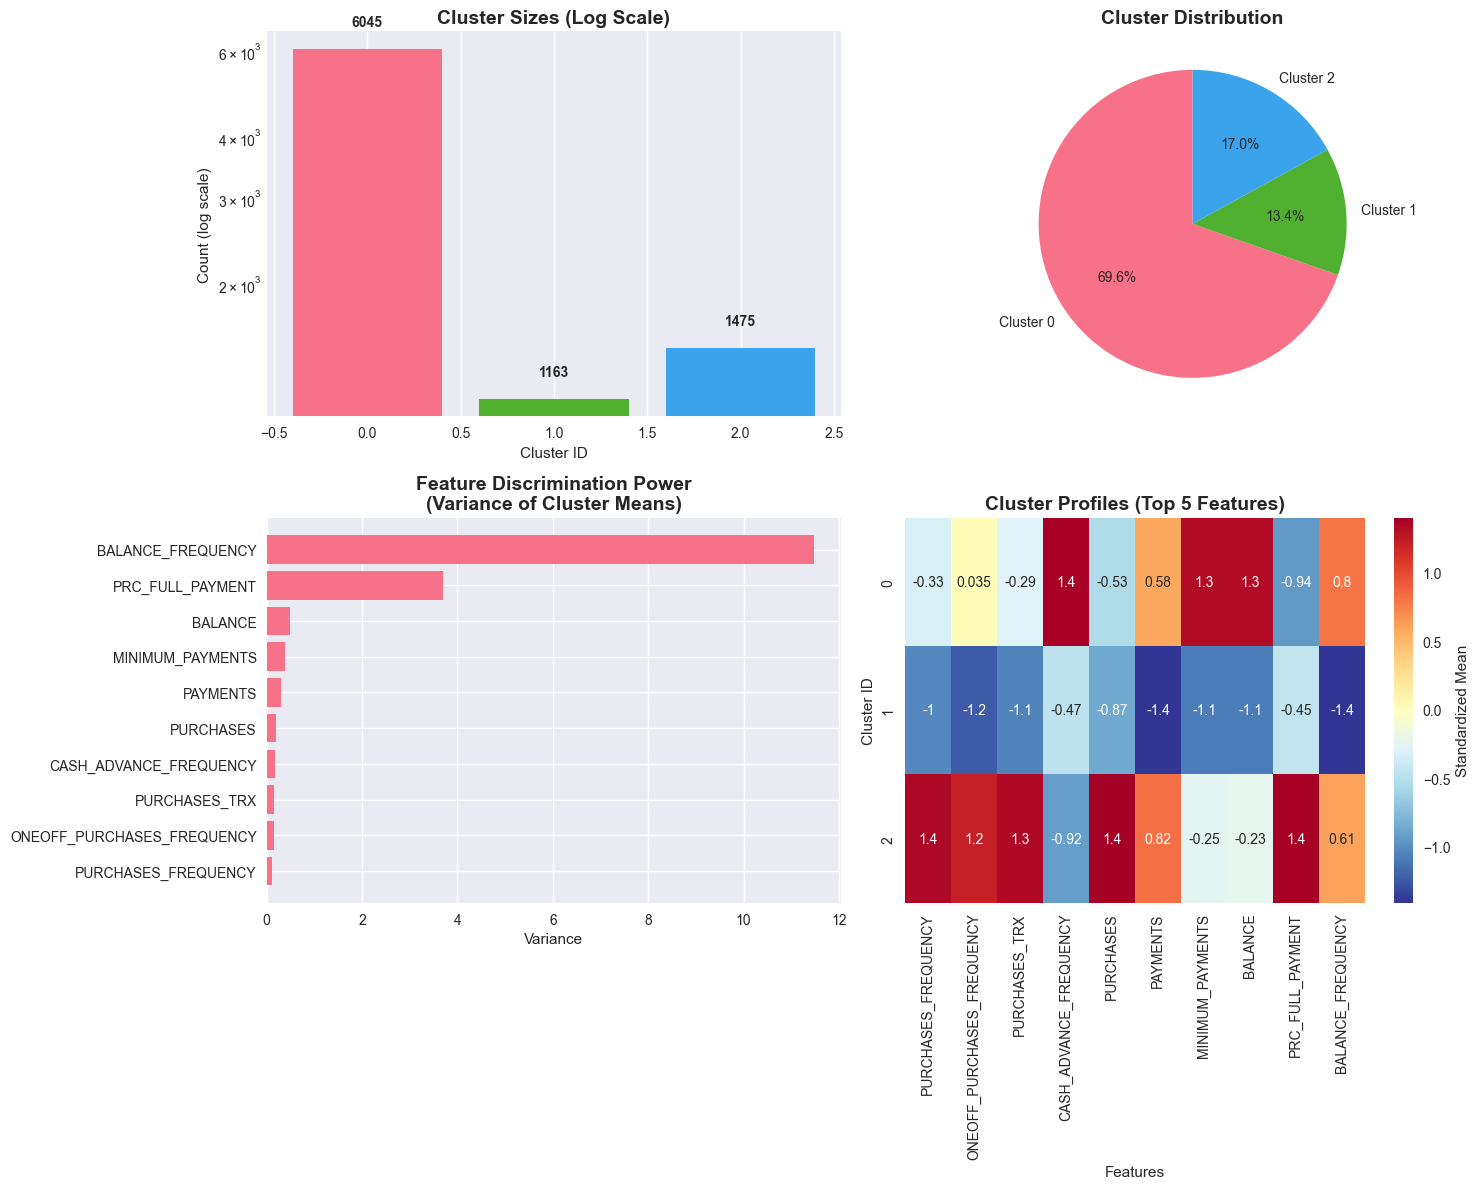

In [513]:
fig1, disc_features = visualizer.plot_cluster_overview()
plt.show()

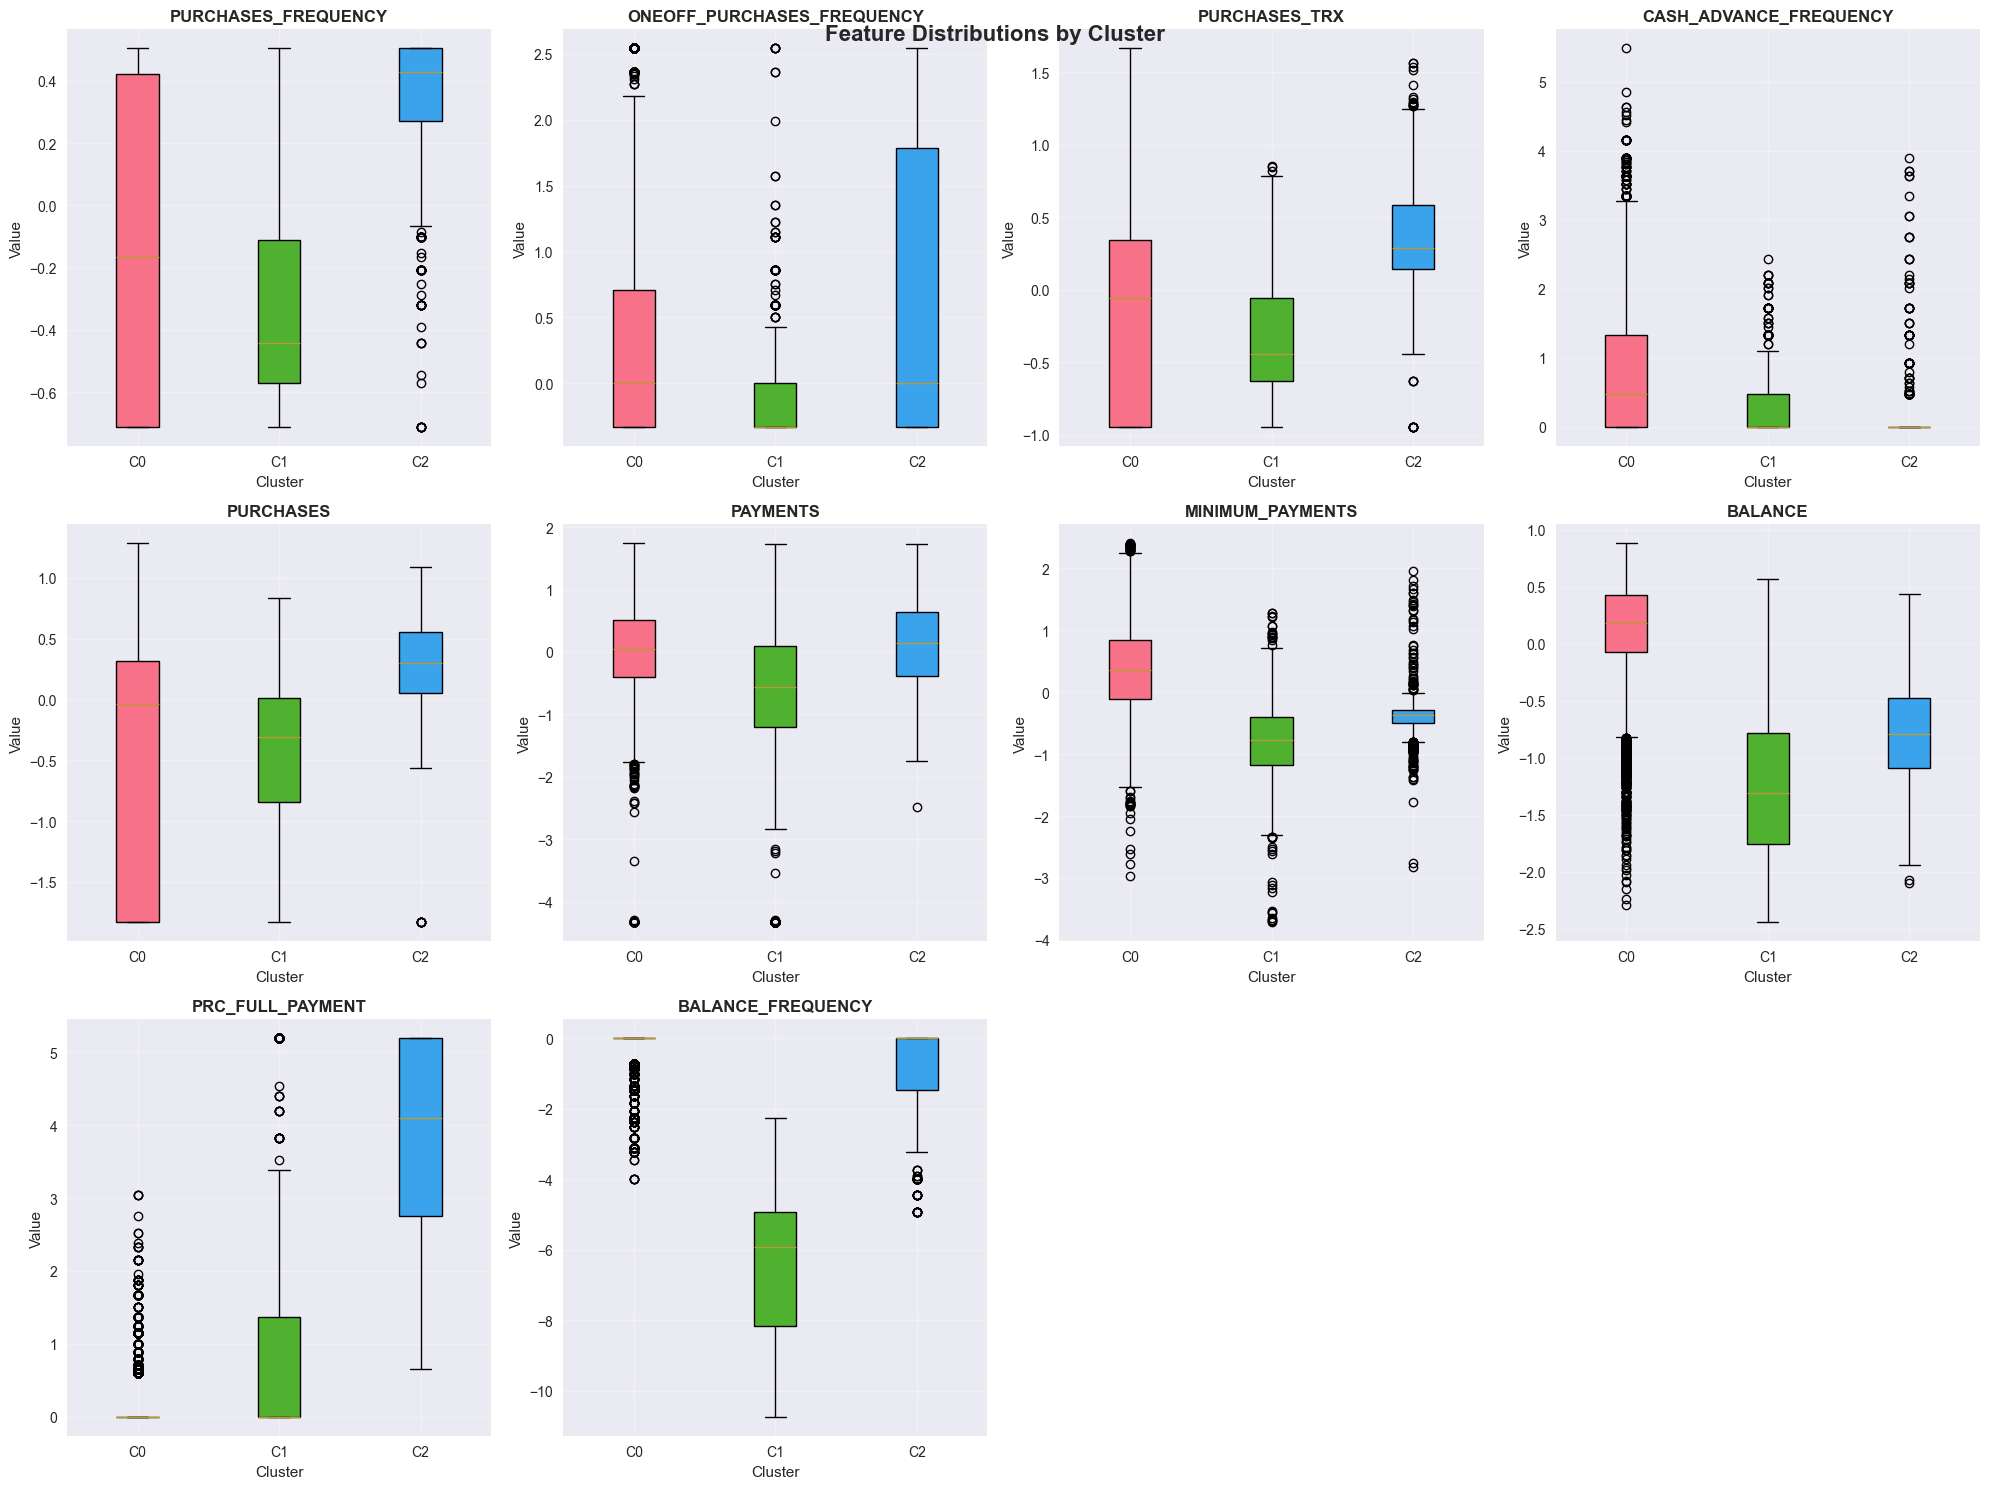

In [515]:
fig2 = visualizer.plot_feature_distributions(features=disc_features)
fig2.suptitle('Feature Distributions by Cluster', fontsize=16, fontweight='bold')
plt.show()